## 2570 Proj 3
___Warren Shi___

In [1]:
## Set up 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.integrate as integrate

%matplotlib inline

### Q1 

### a). simulation function

In [2]:
## i) function for simulation
'''
Function sim_exp
This function takes the intensity parameter alpha and number of simulations n to simulate n iid wait times 
(exponential distribution) for a Poisson Process with intensity alpha. 

parameters:
    alpha: double, the intensity parameter
    n    : double, number of simulations 
    
output:
    np array of length n, the n simulated wait times (exponential variable)
'''
def sim_exp(n = 1, alpha = 3):
    result = -np.log(1 - np.random.uniform(0,1,n)) / alpha
    if n == 1:
        return result[0]
    else: 
        return result

In [3]:
## ii) find N
# we find the variance first from the pilot study
pilot_size = 150
pilot_data = sim_exp(pilot_size)
pilot_var = np.var(pilot_data)
z = st.norm.ppf(0.995)
target_N = int(np.ceil((z*np.sqrt(pilot_var)/0.01)**2))

In [4]:
## iii) find CI
wt_sample = sim_exp(target_N)
e_wt = np.mean(wt_sample)
se_wt = np.sqrt(np.var(wt_sample)/target_N)
CI_lower, CI_upper = e_wt - z * se_wt, e_wt + z * se_wt

In [5]:
print('The required sample size for the CI is: ' + str(target_N)) 
print('The estimated expect value of Wt is   : ' + str(e_wt)) 
print('The 99% confidence interval is        : ' + str((CI_lower, CI_upper))) 

The required sample size for the CI is: 6431
The estimated expect value of Wt is   : 0.33793302901534694
The 99% confidence interval is        : (0.3271710783484505, 0.3486949796822434)


### b). acceptance-rejection

In [6]:
'''
Function pdf_1b
pdf of the distribution in question

parameters:
    alpha: double, the intensity parameter
    n    : double, number of simulations 
    
output:
    np array of length n, the n simulated wait times (exponential variable)
'''
def pdf_1b(x, alpha = 3, t = 1):
    if np.isscalar(x):
        x = np.array(x)
    arr1 = np.where((x<=t) & (x>0), alpha**2 * x * np.exp(-alpha*x), 0)
    arr2 = np.where(x>t, alpha * (1 + alpha * t) * np.exp(-alpha*x), 0)
    return arr1 + arr2

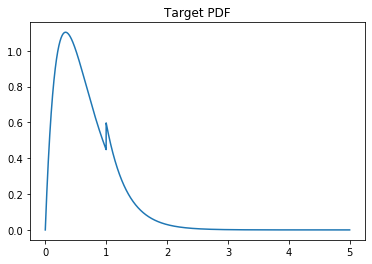

In [7]:
## What our target pdf looks like 
x = np.linspace(0,5,10000)
plt.plot(x, pdf_1b(x))
plt.title('Target PDF');

In [8]:
'''
Function sim_1b
A function that simulates the above pdf through Acceptance-Rejection

parameters:
    None
    
output:
    double, the simulated result
'''
def sim_1b():
    c = 4
    expn = sim_exp()
    if np.random.uniform() <= pdf_1b(expn)/(c*3*np.exp(-3*expn)):
        return expn
    else:
        return sim_1b()

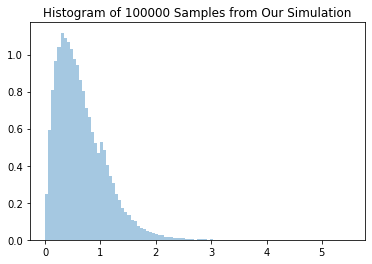

In [9]:
## Graphical illustration of our simulated distribution
try_1b = [sim_1b() for i in range(100000)]
sns.distplot(try_1b, bins = 100, kde = False, norm_hist = True)
plt.title('Histogram of 100000 Samples from Our Simulation');

In [10]:
## Something similar to part a) to find a confidence interval
## get N
pilot_size = 150
pilot_data = [sim_1b() for i in range(pilot_size)]
pilot_var = np.var(pilot_data)
z = st.norm.ppf(0.995)
target_N = int(np.ceil((z*np.sqrt(pilot_var)/0.01)**2))
## get CI
ob_sample = [sim_1b() for i in range(target_N)]
e_1b = np.mean(ob_sample)
se_1b = np.sqrt(np.var(ob_sample)/target_N)
CI_lower, CI_upper = e_1b - z * se_1b, e_1b + z * se_1b
## Output
print('The required sample size for the CI is: ' + str(target_N)) 
print('The estimated expect value of Xt is   : ' + str(e_1b)) 
print('The 99% confidence interval is        : ' + str((CI_lower, CI_upper)))

The required sample size for the CI is: 11535
The estimated expect value of Xt is   : 0.6495777310991598
The 99% confidence interval is        : (0.6390759305634435, 0.6600795316348762)


### c). Control Variate Simulation

In [11]:
## i) function for simulation
'''
Function sim_1c
Vanilla simulation of the inter-arrival interval Xt = Wt+Vt.

parameters:
    n    : double, number of simulations 
    
output:
    xt: np array of length n, the n simulated intervals 
    wt: np array of length n, the n simulated wait times 
'''
def sim_1c(n = 1):
    w0 = sim_exp(n = n)
    vt = np.random.uniform(0,w0)
    wt = sim_exp(n = n)
    xt = wt+vt
    return xt, wt

In [12]:
## Estimate the covariance and correlation between xt and wt through pilot study
pilot_data = sim_1c(10000000)
cov_pilot = np.cov(pilot_data)[0,1]
corr_pilot = np.corrcoef(pilot_data)[0,1]
## variance of wt is 1/lambda(alpah, or 3) squared since wt is exponential
var_wt = 1/9
## get optimal c
c_star = cov_pilot/var_wt
## E(wt) is 1/3 by exponential
v = 1/3
## sample again for the actual controlled variable estimation
xt_control, wt_control = sim_1c(100000)
## get theta by formula
theta = np.mean(xt_control) + c_star*(v-np.mean(wt_control))
theta

0.5002362083546719

In [13]:
np.mean(sim_1c(10000000)[0])

0.4998254636023139

In [14]:
integrate.quad(lambda x: x*pdf_1b(x), 0, 100)

(0.6500709770373041, 4.5855368391301e-09)

In [15]:
print('The estimated mean of Xt through control-variate is: ' + str(theta))
print('The variance of this estimation over the variance of vanilla Monte-Carlo is: ' + str(1-corr_pilot**2))

The estimated mean of Xt through control-variate is: 0.5002362083546719
The variance of this estimation over the variance of vanilla Monte-Carlo is: 0.29407147708765213


## Q2

In [16]:
sims_2 = []
for k in range(100000):
    unif2 = np.random.uniform(0,1,5)
    sims_2.append((int(np.sum([-np.log(unif2[i])*(i+1) for i in range(5)])>=22) + 
                int(np.sum([-np.log(1-unif2[i])*(i+1) for i in range(5)])>=22)) / 2)
print('The estimated Theta is :' + str(np.mean(sims_2)))
print('The variance of this antithetic estimator is: ' + str(np.var(sims_2)))

The estimated Theta is :0.158885
The variance of this antithetic estimator is: 0.05567305677500001


In [17]:
test_2 = []
for k in range(1000000):
    test_2.append(np.sum([np.random.exponential(1)*(i+1) for i in range(5)]) >= 22)
np.mean(test_2)

0.158592

## Q3